In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *
import clustering

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../data/netflix/rating_netflix_one_year.csv')
# df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
# df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5

userList = df['uid'].unique()
itemList = df['iid'].unique()

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d" % (total_usr, total_item))

sparsity of ratings is 1.17%
num. of users: 96684, num. of items: 8394


In [3]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def get_matrix(data):
    matrix = np.zeros((total_usr, total_item), dtype=np.float32)
    for line in data:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        matrix[uid, iid] = 1
    
    return matrix

def train_test_split(df, time_interval, split_rate=0.5):
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    while split_time < end_time:
        df_train = df[df['timestamp'] < split_time]
        df_train = df_train[df_train['timestamp'] >= split_time - 6 * time_interval]
        
        df_test_1 = df[df['timestamp'] >= split_time - 3*time_interval]
        df_test_1 = df_test_1[df_test_1['timestamp'] < split_time]
        
        df_test_2 = df[df['timestamp'] >= split_time]
        df_test_2 = df_test_2[df_test_2['timestamp'] < split_time + time_interval]
        
        # start_time += time_interval
        # split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
        split_time += time_interval
        
        yield df_train, df_test_1, df_test_2

In [4]:
user_map = get_map(userList)
item_map = get_map(itemList)
    
user_time_interval = 14 * 24 * 3600

# New

## Train

In [ ]:
generator = train_test_split(df, user_time_interval)

NUM_CLUSTER = 10
top_items_list_75 = []
top_gt_list_next = []
top_gt_list_now = []

while True:
    try:
        df_train, df_test_now, df_test_next = next(generator)

        train_data = df_train.as_matrix()
        test_data_now = df_test_now.as_matrix()
        test_data_next = df_test_next.as_matrix()

        user_train_matrix = get_matrix(train_data)
        user_test_matrix_now = get_matrix(test_data_now)
        user_test_matrix_next = get_matrix(test_data_next)
        
        train_user = np.nonzero(np.count_nonzero(user_train_matrix, axis=1))[0]
        test_user_now = np.nonzero(np.count_nonzero(user_test_matrix_now, axis=1))[0]
        
        top_n = np.count_nonzero(user_train_matrix, axis=0).argsort()[::-1][:30]
        others = [k for k in range(total_item) if k not in top_n]

        # Train at first to get user_vector
        tf.reset_default_graph()
        autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                                  denoising=True, batch_size=1, epochs=100)

        autoencoder.train_all(rating=user_train_matrix, train_idents=train_user, topN=None, weight=None)

        autoencoder.model_save(1)
        
        # Get specify vectors/feature vectors
        vector_matrices = autoencoder.sess.run(autoencoder.vector_matrix)
        """vector_matrices = autoencoder.sess.run(
            autoencoder.code,
            feed_dict={
                autoencoder.input: user_train_matrix,
                autoencoder.ident: [x for x in range(total_usr)]
            })"""
        exist_vectors = np.take(vector_matrices, train_user, axis=0)
        
        # Clustering
        pca_out = clustering.get_pca_out(exist_vectors)
        kmeans = clustering.calculate_kmeans(pca_out, NUM_CLUSTER=NUM_CLUSTER)
        
        label_index, label_count = clustering.get_cluster_attributes(kmeans, NUM_CLUSTER=NUM_CLUSTER)
        
        # gether input data
        data = {
            'TRAIN_MATRIX': user_train_matrix,
            'TEST_MATRIX_NOW': user_test_matrix_now,
            'TEST_MATRIX_NEXT': user_test_matrix_next,
            'TRAIN_USER': train_user,
            'TEST_USER_NOW': test_user_now,
            'LABEL_INDEX': label_index,
        }
        
        # calculate top_N for each cluster
        cluster_top = clustering.calculate_cluster_top(
            data,
            total_usr,
            total_item,
            NUM_CLUSTER=NUM_CLUSTER,
            batch_size=1,
            weight=100,
            denoising=False)
        
        # calculate score for top items
        score_map = clustering.count_score(cluster_top, label_count, alpha=NUM_CLUSTER)
        
        # get top items
        top_N = clustering.get_score_top(score_map, N=30)
        
        # gether predict top items
        top_items_list_75.append(top_N)
        
        # gether ground truth items
        ground_truth_next = np.count_nonzero(user_test_matrix_next, axis=0).argsort()[::-1][:30]
        ground_truth_now = np.count_nonzero(user_test_matrix_now, axis=0).argsort()[::-1][:30]
        top_gt_list_next.append(ground_truth_next)
        top_gt_list_now.append(ground_truth_now)
                
    except StopIteration:
        break
        

top_items_list_75 = np.asarray(top_items_list_75)
top_gt_list_now = np.asarray(top_gt_list_now)
top_gt_list_next = np.asarray(top_gt_list_next)

In [ ]:
hit_ratio_top_30 = []
hit_ratio_top_10 = []
hit_ratio_top_5 = []
avg_precision_top_30 = []
avg_precision_top_10 = []
avg_precision_top_5 = []

for i, j in zip(top_items_list_75, top_gt_list_now):
    hit_ratio_top_30.append(hit_recall(i, j, N=30))
    hit_ratio_top_10.append(hit_recall(i, j, N=10))
    hit_ratio_top_5.append(hit_recall(i, j, N=5))
    
    k = np.asarray([i])
    q = np.asarray([j])
    avg_precision_top_30.append(avg_precision(k[:, :30], q[:, :30]))
    avg_precision_top_10.append(avg_precision(k[:, :10], q[:, :10]))
    avg_precision_top_5.append(avg_precision(k[:, :5], q[:, :5]))
    

hit_ratio_still_top30 = []
hit_ratio_still_top10 = []
hit_ratio_still_top5 = []
avg_precision_still_30 = []
avg_precision_still_10 = []
avg_precision_still_5 = []

for i, j ,k in zip(top_items_list_75, top_gt_list_now, top_gt_list_next):
    still_in_items_30 = []
    still_in_items_10 = []
    still_in_items_5 = []
    
    for q in k:
        if q in j:
            still_in_items_30.append(q)
            
    for q in k[:10]:
        if q in j[:10]:
            still_in_items_10.append(q)
            
    for q in k[:5]:
        if q in j[:5]:
            still_in_items_5.append(q)
            
    hit_ratio_still_top30.append(hit_recall(i, still_in_items_30, N=30))
    hit_ratio_still_top10.append(hit_recall(i, still_in_items_10, N=10))
    hit_ratio_still_top5.append(hit_recall(i, still_in_items_5, N=5))
    
    x = np.asarray([i])
    y_30 = np.asarray([still_in_items_30])
    y_10 = np.asarray([still_in_items_10])
    y_5 = np.asarray([still_in_items_5])
    
    avg_precision_still_30.append(avg_precision(x[:, :30], y_30))
    avg_precision_still_10.append(avg_precision(x[:, :10], y_10))
    avg_precision_still_5.append(avg_precision(x[:, :5], y_5))

In [ ]:
plt.plot(range(len(hit_ratio_top_30)), hit_ratio_top_30, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NOW')
plt.show()
plt.gcf().clear()
print ("Hit ratio top 30: %f" % (sum(hit_ratio_top_30)/len(hit_ratio_top_30)))
print ("Hit ratio top 10: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("Hit ratio top 5: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
plt.plot(range(len(hit_ratio_still_top10)), hit_ratio_still_top10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NEXT')
plt.show()
plt.gcf().clear()
print ("Still in hit ratio top 30: %f" % (sum(hit_ratio_still_top30)/len(hit_ratio_still_top30)))
print ("Still in hit ratio top 10: %f" % (sum(hit_ratio_still_top10)/len(hit_ratio_still_top10)))
print ("Still in hit ratio top 5: %f" % (sum(hit_ratio_still_top5)/len(hit_ratio_still_top5)))

In [ ]:
print ("Avg. precision top 30: %f" % (sum(avg_precision_top_30)/len(avg_precision_top_30)))
print ("Avg. precision top 10: %f" % (sum(avg_precision_top_10)/len(avg_precision_top_10)))
print ("Avg. precision top 5: %f" % (sum(avg_precision_top_5)/len(avg_precision_top_5)))
print ()
print ("Avg.precision still top 30: %f" % (sum(avg_precision_still_30)/len(avg_precision_still_30)))
print ("Avg.precision still top 10: %f" % (sum(avg_precision_still_10)/len(avg_precision_still_10)))
print ("Avg.precision still top 5: %f" % (sum(avg_precision_still_5)/len(avg_precision_still_5)))

# Old

# Still in ratio

In [5]:
generator = train_test_split(df, user_time_interval, split_rate=0.5)
count = 0
still_in_ratio = []
while True:
    try:
        df_train, df_test_1, df_test_2 = next(generator)
        
        test_data_1 = df_test_1.as_matrix()
        test_data_2 = df_test_2.as_matrix()
        user_test_matrix_1 = get_matrix(test_data_1)
        user_test_matrix_2 = get_matrix(test_data_2)
        

        ground_truth_next = np.count_nonzero(user_test_matrix_2, axis=0).argsort()[::-1][:30]
        ground_truth_now = np.count_nonzero(user_test_matrix_1, axis=0).argsort()[::-1][:30]
        
        still_in = hit_recall(ground_truth_next, ground_truth_now, N=30)
        
        still_in_ratio.append(still_in)
        count += 1
        print (count)
        
    except StopIteration:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13


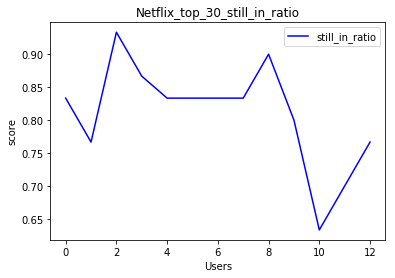

0.8102564102564103


In [6]:
plt.plot(range(len(still_in_ratio)), still_in_ratio, color='blue', label='still_in_ratio')
plt.legend(loc="upper right")
plt.title("Netflix_top_30_still_in_ratio")
plt.xlabel('Users')
plt.ylabel('score')
plt.savefig("./prediction_weekly/Netflix_still_in_top_30.jpg")
plt.show()
plt.gcf().clear()

print (sum(still_in_ratio)/len(still_in_ratio))

## Train

In [8]:
generator = train_test_split(df, user_time_interval)

tf.reset_default_graph()

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                          with_weight=False, denoising=True, batch_size=100, epochs=200)

test_out_top = []
# top_items_list_all = []
top_items_list_75 = []
# top_items_list_85 = []
# top_means_list = []
top_gt_list_next = []
top_gt_list_now = []

while True:
    try:
        df_train, df_test_1, df_test_2 = next(generator)

        train_data = df_train.as_matrix()
        test_data_1 = df_test_1.as_matrix()
        test_data_2 = df_test_2.as_matrix()

        user_train_matrix = get_matrix(train_data)
        user_test_matrix_1 = get_matrix(test_data_1)
        user_test_matrix_2 = get_matrix(test_data_2)
        
        top_n = np.count_nonzero(user_train_matrix, axis=0).argsort()[::-1][:30]
        others = [k for k in range(total_item) if k not in top_n]

        train_user = np.nonzero(np.count_nonzero(user_train_matrix, axis=1))[0]
        test_user_1 = np.nonzero(np.count_nonzero(user_test_matrix_1, axis=1))[0]

        autoencoder.train_all(rating=user_train_matrix, train_idents=train_user, topN=None, weight=None)

        test_out = autoencoder.predict(user_test_matrix_1, test_user_1)
        
        """ out data process """
        # all data mean
        # test_out_stat_all = np.mean(test_out, axis=0)
        
        # upper quartile mean
        test_out_stat_75 = []
        quartile_75 = np.percentile(test_out, 75, axis=0)
        for i in range(test_out.shape[1]):
            test_out_stat_75.append(np.mean([x for x in test_out.T[i] if x > quartile_75[i]]))
        test_out_stat_75 = np.asarray(test_out_stat_75)
        
        """test_out_stat_85 = []
        quartile_85 = np.percentile(test_out, 85, axis=0)
        for i in range(test_out.shape[1]):
            test_out_stat_85.append(np.mean([x for x in test_out.T[i] if x > quartile_85[i]]))
        test_out_stat_85 = np.asarray(test_out_stat_85)"""
        
        """Get top 10"""
        # test_out_rank_all = test_out_stat_all.argsort()[::-1][:30]
        test_out_rank_75 = test_out_stat_75.argsort()[::-1][:30]
        # test_out_rank_85 = test_out_stat_85.argsort()[::-1][:30]
        ground_truth_next = np.count_nonzero(user_test_matrix_2, axis=0).argsort()[::-1][:30]
        ground_truth_now = np.count_nonzero(user_test_matrix_1, axis=0).argsort()[::-1][:30]
        
        """out data collect"""
        # top_out = np.take(test_out, test_out_rank_all, axis=1).T
        # test_out_top.append(top_out)
        
        # top_items_list_all.append(test_out_rank_all)
        top_items_list_75.append(test_out_rank_75)
        # top_items_list_85.append(test_out_rank_85)
        top_gt_list_next.append(ground_truth_next)
        top_gt_list_now.append(ground_truth_now)
        
        """means = []
        for i in test_out_rank_all:
            means.append((i, test_out_stat_all[i]))
        top_means_list.append(means)"""
        
    except StopIteration:
        break
        
# top_items_list_all = np.asarray(top_items_list_all)
top_items_list_75 = np.asarray(top_items_list_75)
# top_items_list_85 = np.asarray(top_items_list_85)
# top_means_list = np.asarray(top_means_list)
top_gt_list_now = np.asarray(top_gt_list_now)
top_gt_list_next = np.asarray(top_gt_list_next)

100%|██████████| 200/200 [10:18<00:00,  3.07s/it]


for i in trange(top_means_list.shape[0]):
    for j in range(top_means_list.shape[1]):
        if top_items_list_all[i][j] in top_gt_list_now[i]:
            plt.plot(range(len(test_out_top[i][j])), test_out_top[i][j], color='green', label='pred. scores')
            plt.hlines(top_means_list[i][j][1], -5, len(test_out_top[i][j])+5, linestyles='solid', color='blue')
            plt.legend(loc="upper right")
            plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list_all[i][j], top_means_list[i][j][1]))
            plt.xlabel('Users')
            plt.ylabel('score')
            plt.savefig("plots_netflix_now/scores_%d_%d.jpg" % (i, j))
        else:
            plt.plot(range(len(test_out_top[i][j])), test_out_top[i][j], color='red', label='pred. scores')
            plt.hlines(top_means_list[i][j][1], -5, len(test_out_top[i][j])+5, linestyles='solid', color='blue')
            plt.legend(loc="upper right")
            plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list_all[i][j], top_means_list[i][j][1]))
            plt.xlabel('Users')
            plt.ylabel('score')
            plt.savefig("plots_netflix_now/scores_%d_%d.jpg" % (i, j))
        plt.show()
        plt.gcf().clear()

# ITRI

In [17]:
hit_ratio_top_30 = []
hit_ratio_top_10 = []
hit_ratio_top_5 = []
avg_precision_top_30 = []
avg_precision_top_10 = []
avg_precision_top_5 = []

for i, j in zip(top_items_list_75, top_gt_list_now):
    
    hit_ratio_top_30.append(hit_recall(i, j, N=30))
    hit_ratio_top_10.append(hit_recall(i, j, N=10))
    hit_ratio_top_5.append(hit_recall(i, j, N=5)) 
    
    k = np.asarray([i])
    q = np.asarray([j])
    avg_precision_top_30.append(avg_precision(k[:, :30], q[:, :30]))
    avg_precision_top_10.append(avg_precision(k[:, :10], q[:, :10]))
    avg_precision_top_5.append(avg_precision(k[:, :5], q[:, :5]))

In [15]:
hit_ratio_still_top30 = []
hit_ratio_still_top10 = []
hit_ratio_still_top5 = []
avg_precision_still_30 = []
avg_precision_still_10 = []
avg_precision_still_5 = []

for i, j ,k in zip(top_items_list_75, top_gt_list_now, top_gt_list_now):
    still_in_items_30 = []
    still_in_items_10 = []
    still_in_items_5 = []
    
    f = np.asarray([i])
    
    for q in k:
        if q in j:
            still_in_items_30.append(q)
            
    for q in k[:10]:
        if q in j[:10]:
            still_in_items_10.append(q)
            
    for q in k[:5]:
        if q in j[:5]:
            still_in_items_5.append(q)
            
    hit_ratio_still_top30.append(hit_recall(i, still_in_items_30, N=30))
    hit_ratio_still_top10.append(hit_recall(i, still_in_items_10, N =10))
    hit_ratio_still_top5.append(hit_recall(i, still_in_items_5, N=5))
    
    x = np.asarray([i])
    y_30 = np.asarray([still_in_items_30])
    y_10 = np.asarray([still_in_items_10])
    y_5 = np.asarray([still_in_items_5])
    
    avg_precision_still_30.append(avg_precision(x[:, :30], y_30))
    avg_precision_still_10.append(avg_precision(x[:, :10], y_10))
    avg_precision_still_5.append(avg_precision(x[:, :5], y_5))

## upper quartile mean

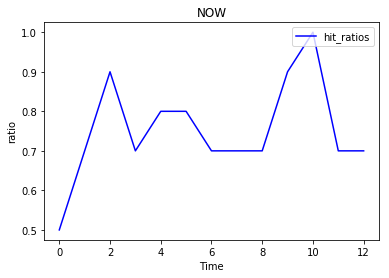

Hit ratio top 30: 0.887179
Hit ratio top 10: 0.753846
Hit ratio top 5: 0.707692


In [18]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NOW')
plt.show()
plt.gcf().clear()
print ("Hit ratio top 30: %f" % (sum(hit_ratio_top_30)/len(hit_ratio_top_30)))
print ("Hit ratio top 10: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("Hit ratio top 5: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

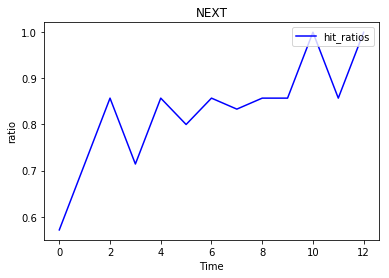

Still in hit ratio top 30: 0.931161
Still in hit ratio top 10: 0.828938
Still in hit ratio top 5: 0.750000


In [12]:
plt.plot(range(len(hit_ratio_still_top10)), hit_ratio_still_top10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NEXT')
plt.show()
plt.gcf().clear()
print ("Still in hit ratio top 30: %f" % (sum(hit_ratio_still_top30)/len(hit_ratio_still_top30)))
print ("Still in hit ratio top 10: %f" % (sum(hit_ratio_still_top10)/len(hit_ratio_still_top10)))
print ("Still in hit ratio top 5: %f" % (sum(hit_ratio_still_top5)/len(hit_ratio_still_top5)))

In [ ]:
print ("Avg. precision top 30: %f" % (sum(avg_precision_top_30)/len(avg_precision_top_30)))
print ("Avg. precision top 10: %f" % (sum(avg_precision_top_10)/len(avg_precision_top_10)))
print ("Avg. precision top 5: %f" % (sum(avg_precision_top_5)/len(avg_precision_top_5)))
print ()
print ("Avg.precision still top 30: %f" % (sum(avg_precision_still_30)/len(avg_precision_still_30)))
print ("Avg.precision still top 10: %f" % (sum(avg_precision_still_10)/len(avg_precision_still_10)))
print ("Avg.precision still top 5: %f" % (sum(avg_precision_still_5)/len(avg_precision_still_5)))

## Upper 85 mean

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NOW')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NEXT')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

# Netflix

## all data mean

In [ ]:
print ("TOP 10 NOW: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NOW: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
print ("TOP 10 NEXT: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NEXT: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

## upper quartile mean

In [ ]:
print ("TOP 10 NOW: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NOW: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
print ("TOP 10 NEXT: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NEXT: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

## Upper 85 mean

In [ ]:
print ("TOP 10 NOW: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NOW: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
print ("TOP 10 NEXT: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NEXT: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

# TOP N Ratio

In [ ]:
generator = train_test_split(df, user_time_interval)

gt_list = []
gtt = []
while True:
    try:
        df_train, df_test_1, df_test_2 = next(generator)

        test_data_2 = df_test_2.as_matrix()

        user_test_matrix_2 = get_matrix(test_data_2)
        
        ground_truth_idx = np.count_nonzero(user_test_matrix_2, axis=0).argsort()[::-1][:30]
        ground_truth = np.take(np.count_nonzero(user_test_matrix_2, axis=0), ground_truth_idx)
        
        ground_truth_rate = np.divide(sum(ground_truth), sum(np.count_nonzero(user_test_matrix_2, axis=0)))
        gt_list.append(ground_truth_rate)
        gtt.append(user_test_matrix_2.shape[0])
    except StopIteration:
        break


## ITRI TOP N ratio

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 30')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 10')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

## Netflix Top N ratio

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 30')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 10')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

# Debug

In [ ]:
# from sklearn.model_selection import train_test_split

df_train, df_test, _, _ = next(generator)

train_data = df_train.as_matrix()
test_data = df_test.as_matrix()

user_train_rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in train_data:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    user_train_rating[uid, iid] = 1
    
item_train_rating = user_train_rating.T

In [ ]:
a = np.percentile(test_out, 75, axis=0)
k = []
for i in range(test_out.shape[1]):
    k.append(np.mean([x for x in test_out.T[i] if x > a[i]]))

In [ ]:
print (len(sorted(k, reverse=True)))